In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# eEF2 prepping

before we can map each peak to a constrained search axis, we must prep the eEF2 data

***

In [27]:
treated_eEF2_dir = "/Users/brose/Desktop/Lucas_lab/CHX_eEF2_locked_in/eEF2_finding/CHX_treated"
untreated_eEF2_dir = "/Users/brose/Desktop/Lucas_lab/CHX_eEF2_locked_in/eEF2_finding/untreated"

## CHX-Treated eEF2: 

### Data preparation

CHX-Treated eEF2 will be processed with scripts from `utils.py` module
- First, we will create a dictionary with our data.
- Then, we will match peaks by particle_index and then produce match-stats and log2 ratios (eEF2/60S)

In [43]:
from utils import *

def treated_image_filepattern(in_path):
    spl = in_path.split("_")
    if spl[1] == "eEF2":
        img_name = in_path.split("eEF2_")[1].split("_rt_results")[0]
    elif spl[1] == "60S":
        img_name = in_path.split("control_")[1].split("_rt_results")[0]
    else:
        raise FileNotFoundError(f"File ({in_path}) does not fit the filepattern!")
    return img_name

datadict_treated = make_datadict(treated_eEF2_dir, "eEF2", treated_image_filepattern)
treated_60S = {image: value["control"] for image, value in datadict_treated.items()}
match_stats_treated, log2s_treated = match_and_compute_log2s(datadict_treated)


File (pluh_pluh_pluh.txt) does not fit the filepattern!
skipping....


### Pre-analysis plots

We will plot the raw data (raw log2 ratios, matched statisttics) using scripts from `utils.py`

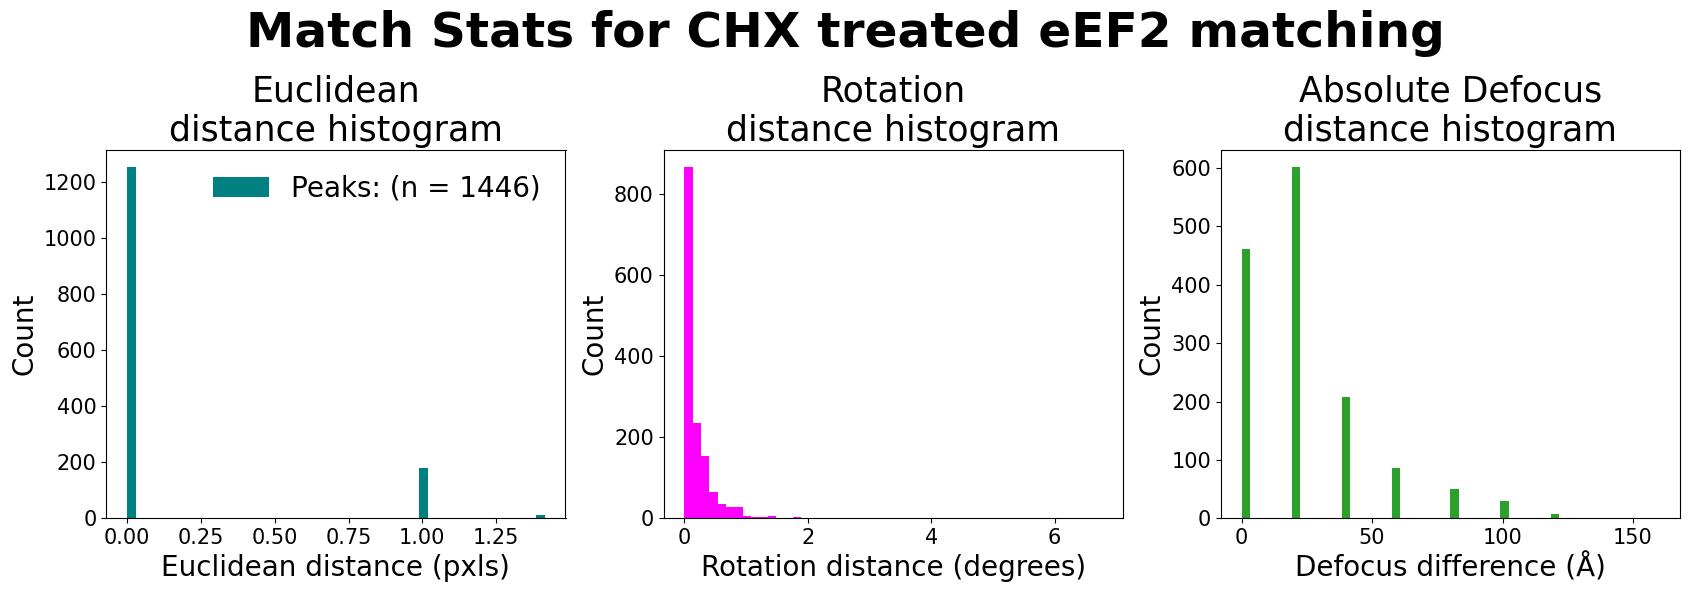

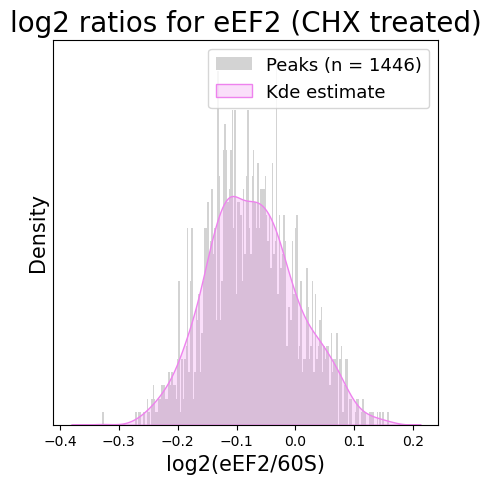

In [44]:
plot_match_stats(match_stats_treated, "CHX treated eEF2 matching")
plot_initial_ratios(log2s_treated, "(CHX treated)")

### GMM fitting

We will use `sklearn` to fit a gaussian mixture model to the data with a variable number of components, and then we will calculate the [Bayesian Information Criterion](https://www.geeksforgeeks.org/machine-learning/bayesian-information-criterion-bic/) (or BIC), a metric used to avoid overfitting. We will also include the [Akaike Information Criterion](https://www.scribbr.com/statistics/akaike-information-criterion/) here, because that is more valid for smaller datasets

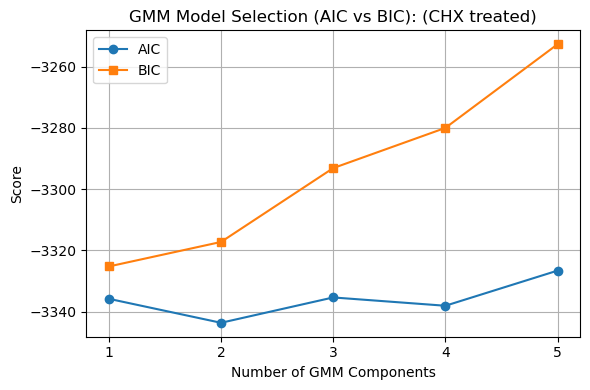

Best model by BIC: 1 components (BIC = -3325.24)
Best model by BIC: 2 components (AIC = -3343.62)


In [45]:
select_best_gmm(log2s_treated, "(CHX treated)")

### Fitting 2 Gaussians to the data

Although the BIC is minimized with one component, I have previously used 2 components to see eEF2, and have successfully seen it. Additionally, this sample size is small, and the BIC is not **that** much higher with 2 components. 

Because the AIC fits 2 models here, and my previous experience, I feel *somewhat* confident using a 2 component GMM'

We will: 
- Plot the data with the 2 fit components
- Calculate the likelihood any log2 ratio belongs to the components
- Filter depending on the likelihood (higher than 0.85) and log2 ratio (higher than 0.0) 

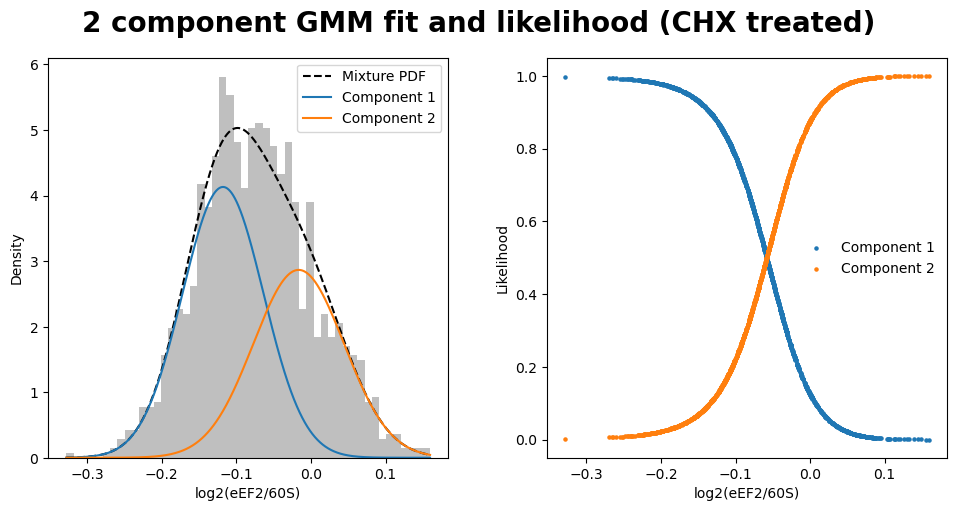

17.15% of peaks (248) have the protein of interest!


In [46]:
log2s_w_likelihoods_treated = fit_gmms_and_likelihoods(log2s_treated, "(CHX treated)")
filtered_log2s_treated = filter_log2_ratios(log2s_w_likelihoods_treated, 2, likelihood_threshold=0.85)

***



## Untreated Data prep 

We will prep this data the same way

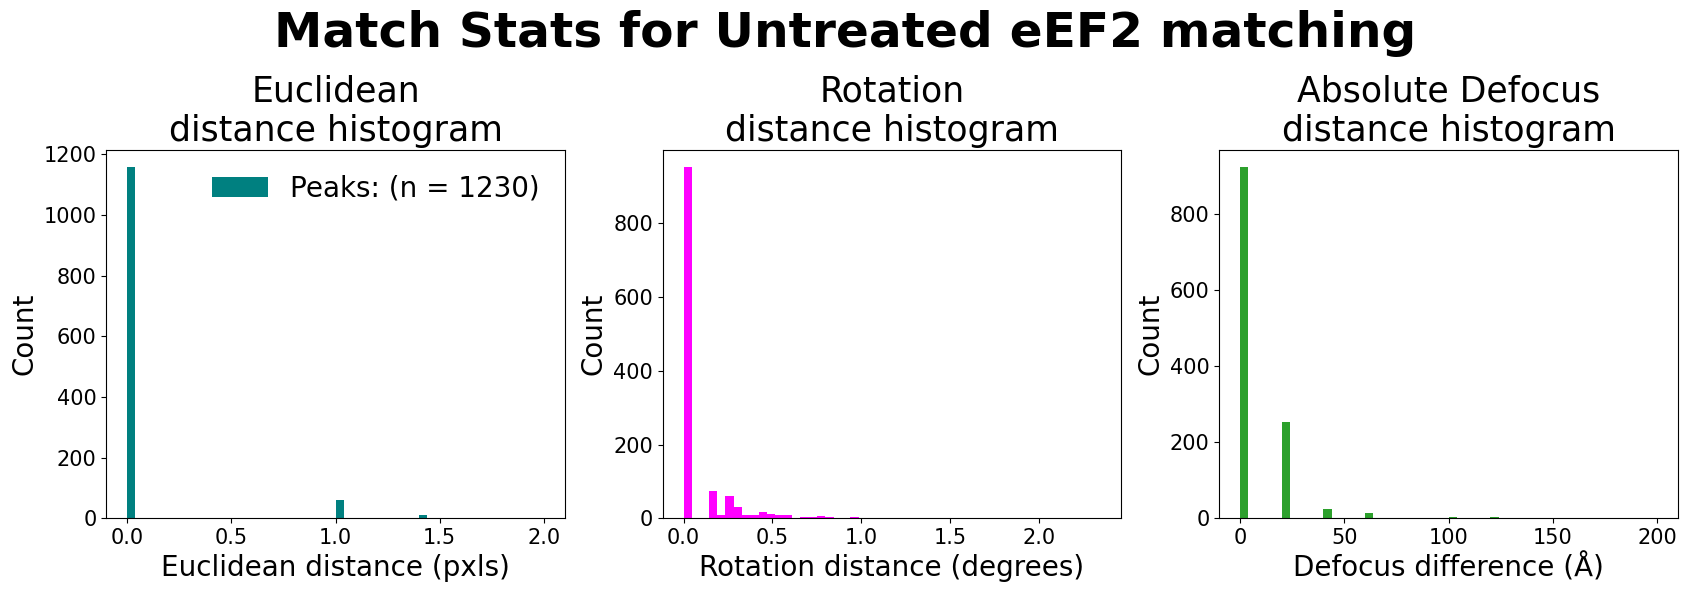

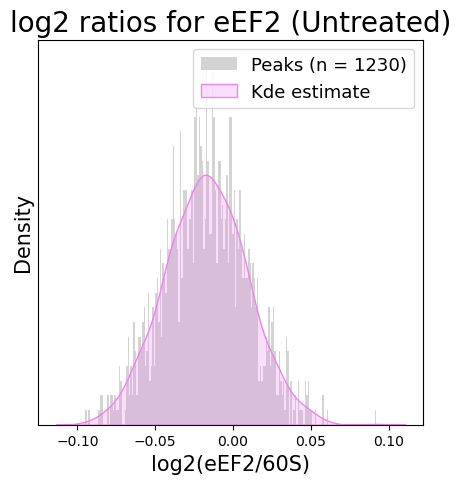

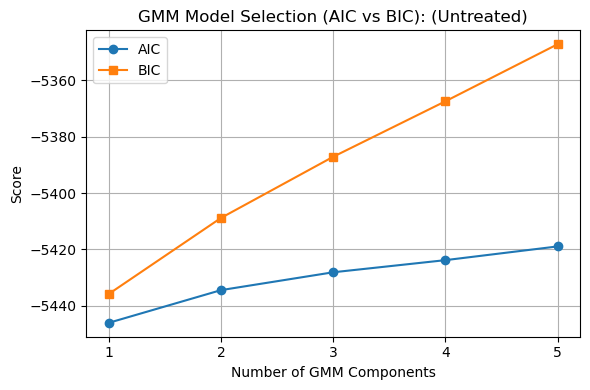

Best model by BIC: 1 components (BIC = -5435.74)
Best model by BIC: 1 components (AIC = -5445.97)


In [49]:
def untreated_image_filepattern(path_in):
    return path_in.split("img_")[1].split("_DWS")[0]
datadict_untreated = make_datadict(untreated_eEF2_dir, "eEF2", untreated_image_filepattern)
untreated_60S = {image: value["control"] for image, value in datadict_untreated.items()}
match_stats_untreated, log2s_untreated = match_and_compute_log2s(datadict_untreated)
plot_match_stats(match_stats_untreated, "Untreated eEF2 matching")
plot_initial_ratios(log2s_untreated, "(Untreated)")
select_best_gmm(log2s_untreated, "(Untreated)")

### should I really be fitting a 2-component GMM to the model?

No. probably not. This may not be a fully valid method. However, it is important that we analyze the data the same way for control purposes. I am continuing to analyze this way because I think it will 

In [ ]:

log2s_w_likelihoods_untreated = fit_gmms_and_likelihoods(log2s_untreated, "(untreated)")
filtered_log2s_untreated = filter_log2_ratios(log2s_w_likelihoods_untreated, 2, likelihood_threshold=0.85)

***

# Constrained search prepping 

## CHX-treated

We will focus on two axes for CHX-treated, since two axes can describe ~75% of the rotation states for this dataset.

![CHX axes 7N8B → 5JUO and 8CCS → 6Q8Y can describe ~75% of rotations, with roughly 40% of rotations described by both](Images/treated_pie.png)

7N8B → 5JUO and 8CCS → 6Q8Y will be used

In [33]:
untreated_cs = "/Users/brose/Desktop/Lucas_lab/CHX_eEF2_locked_in/untreated/cs_results"
treated_cs = "/Users/brose/Desktop/Lucas_lab/CHX_eEF2_locked_in/axis_finding/constrained_search_results"

In [34]:
def treated_cs_filepattern(in_path):
    return in_path.split("img_")[1].split("_axis")[0]
def untreated_cs_filepattern(in_path):
    return in_path.split("img_")[1].split("_DWS")[0]

## filtering dataframes and plotting eEF2 overlaps

- First, we load the data by image 
- Then, we match by image to the filtered log2s data and check the overlap with the 40S


In [35]:
from utils import *
import matplotlib.pyplot as plt
treated_axes = [
    ("7N8B", "5JUO"), 
    ("8CCS", "6Q8Y")
        ]
datadict_treated_40S = load_constrained_search_paths(treated_cs, treated_axes, treated_cs_filepattern)
cleaned_40S_treated = determine_axis_overlap(datadict_treated_40S, treated_axes)
matched_eEF2_40S_treated = match_poi_to_40S(filtered_log2s_treated, cleaned_40S_treated, treated_60S)
matched_eEF2_40S_treated

,particle_index,mip,scaled_mip,refined_mip,refined_scaled_mip,correlation_mean,correlation_variance,total_correlations,pos_x,pos_y,...,psi_path,theta_path,phi_path,defocus_path,correlation_average_path,correlation_variance_path,index_combo,contains_eEF2,best_axis,rotation_state
0,0,14.010820,13.548291,14.374521,14.119601,0.032683,1.031727,20598240,3046,915,...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,"(0, 95_Sep12_18.17.26_207_1)",False,False,False
1,1,13.739036,13.145228,15.813280,15.407391,0.123834,1.035752,20598240,2421,802,...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,"(1, 95_Sep12_18.17.26_207_1)",False,"(8CCS, 6Q8Y)",97.5
2,2,13.522823,13.000218,14.762692,14.416451,0.130381,1.030171,20598240,1287,1189,...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,"(2, 95_Sep12_18.17.26_207_1)",False,"(7N8B, 5JUO)",93.0
3,3,13.368804,12.615880,14.230687,13.766960,0.125596,1.049725,20598240,2216,959,...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,"(3, 95_Sep12_18.17.26_207_1)",False,"(8CCS, 6Q8Y)",95.5
4,4,12.792860,12.560507,14.503300,14.328040,0.099925,1.010543,20598240,1763,1279,...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,../60S_rt_results/mips/8CCS_60S_95_Sep12_18.17...,"(4, 95_Sep12_18.17.26_207_1)",False,"(8CCS, 6Q8Y)",96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,623,7.780533,7.914050,8.501135,8.394033,-0.026609,0.986491,20598240,3134,3049,...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,"(623, 138_Sep13_11.05.15_233_1)",False,False,False
1442,624,8.012204,7.900137,10.112825,10.054822,0.072305,1.005033,20598240,401,2819,...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,"(624, 138_Sep13_11.05.15_233_1)",False,"(7N8B, 5JUO)",92.0
1443,625,7.999879,7.866564,8.544175,8.483778,0.115374,1.002281,20598240,4246,1227,...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,../60S_rt_results/mips/8CCS_60S_138_Sep13_11.0...,"(625, 138_Sep13_11.05.15_233_1)",False,False,False
1444,626,8.199566,7.857194,8.989913,9.001344,0.070126,1.034649,20598240,4110,1905,...,../60S_rt_results/mips/8

## Pre-analysis visualization 

- How many eEF2-containing peaks contain a 40S subunit?
- How many 40S subunits do we see?
- How many peaks contain eEF2?

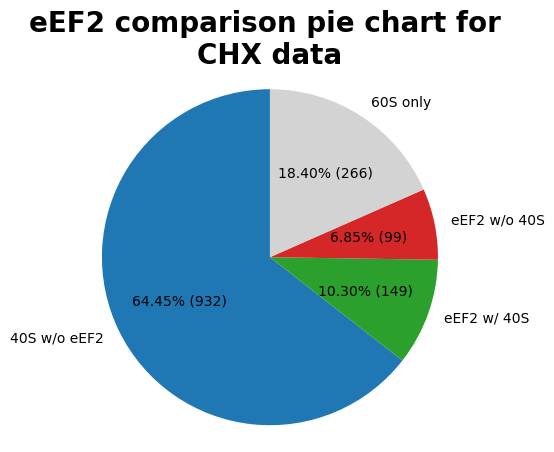

In [36]:
from utils import *
plot_overlaps(matched_eEF2_40S_treated, "\nCHX data")

## Analysis

- Plot heatmap of axes with rotation state?

***

## Untreated analysis; the same way as before

except, this time, the axes will be different

![pie chart of the untreated data, two other axes predominate](Images/untreated_pie.png)

We will use 6Q8Y → 7N8B and 8CCS → 8CDR

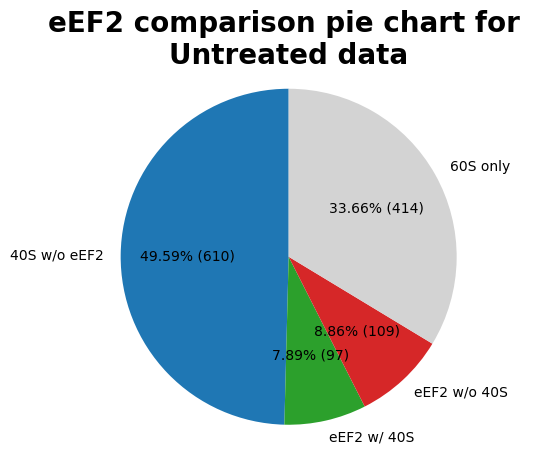

In [37]:
from utils import *
untreated_axes = [
    ("6Q8Y", "7N8B"), 
    ("8CDR", "orig_axis")
        ]
datadict_untreated_40S = load_constrained_search_paths(untreated_cs, untreated_axes, untreated_cs_filepattern)
cleaned_40S_untreated = determine_axis_overlap(datadict_untreated_40S, untreated_axes)
matched_eEF2_40S_untreated = match_poi_to_40S(filtered_log2s_untreated, cleaned_40S_untreated, untreated_60S)
plot_overlaps(matched_eEF2_40S_untreated, "\nUntreated data")